In [1]:
!git clone https://github.com/Coeze/MX4553_Modelling_Theory_Project.git

Cloning into 'MX4553_Modelling_Theory_Project'...
remote: Enumerating objects: 497, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 497 (delta 50), reused 13 (delta 13), pack-reused 428 (from 4)
Receiving objects: 100% (497/497), 11.27 MiB | 13.87 MiB/s, done.
Resolving deltas: 100% (267/267), done.


In [2]:
%cd MX4553_Modelling_Theory_Project

/content/MX4553_Modelling_Theory_Project


In [3]:
!pip install fiona rasterio numpy pandas scikit-learn matplotlib matplotlib-scalebar geopandas pyproj shapely deap noise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 6.3 MB/s eta 0:00:00
  Created wheel for noise: filename=noise-1.2.2-cp311-cp311-linux_x86_64.whl size=56281 sha256=be99311dd170bd7f26ce4b2d859d7d064fbd5b3a877709f9453aefb6438be09c
  Stored in directory: /root/.cache/pip/wheels/39/25/2e/af6d1bcc91a8f99af0f651f8718b9ab999720a21c6d4149091
Successfully built noise


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.model import CA

from noise import snoise2


In [5]:
# Load the real Pine Hollow fire data
fire = "arizona"
grid_size = (250,250)
model = CA(grid_size=grid_size, cell_size=1, params={'p0':0.6115, 'c1':0.1225, 'c2':0.3475})
model.load_mtbs_fire_data(fire)
model.initialise_ndvi_from_data(fire)

Loaded burn perimeter shapefile: data/az3698311211020200729/az3698311211020200729_20200714_20210717_burn_bndy.shp
Loaded DNBR raster: data/az3698311211020200729/az3698311211020200729_20200714_20210717_dnbr.tif
Initializing from arizona fire
Loaded burn perimeter successfully
Resampling DNBR data from (565, 499) to (250, 250)
Estimated NDVI from DNBR data


True

In [6]:
def generate_terrain_simplex(rows, cols, cell_size=30.0, min_elevation=100, max_elevation=1000,
                           octaves=6, persistence=0.5, lacunarity=2.0, scale=100.0, seed=None):
    """
    Generate realistic terrain elevation, slope, and aspect using Simplex noise.

    Parameters:
    - rows, cols: Dimensions of the grid
    - cell_size: Size of each cell in meters
    - min_elevation, max_elevation: Range of elevation values in meters
    - octaves: Number of noise layers to combine (more = more detail)
    - persistence: How much each octave contributes (amplitude multiplier)
    - lacunarity: How frequency increases with each octave
    - scale: Base scale of the noise (higher = more gradual changes)
    - seed: Random seed for reproducibility

    Returns:
    - elevation: 2D numpy array of elevation values
    - slope: 2D numpy array of slope values in degrees
    - aspect: 2D numpy array of aspect values in degrees (0-360, 0=North)
    """

    if seed is not None:
        np.random.seed(seed)

    # Generate elevation using simplex noise
    elevation = np.zeros((rows, cols))

    # For better performance, vectorize the coordinates
    y_coords = np.linspace(0, scale, rows)
    x_coords = np.linspace(0, scale, cols)

    for octave in range(octaves):
        frequency = lacunarity ** octave
        amplitude = persistence ** octave

        for i, y in enumerate(y_coords):
            for j, x in enumerate(x_coords):
                elevation[i, j] += amplitude * snoise2(
                    y * frequency / scale,
                    x * frequency / scale
                )

    # Normalize to 0-1 range
    elevation_min = elevation.min()
    elevation_max = elevation.max()
    elevation = (elevation - elevation_min) / (elevation_max - elevation_min)

    # Scale to desired elevation range
    elevation = min_elevation + elevation * (max_elevation - min_elevation)

    # Calculate slope and aspect from elevation using gradients
    dy, dx = np.gradient(elevation, cell_size, cell_size)

    # Calculate slope in degrees
    # Slope is the angle of steepest descent
    slope = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))

    # Calculate aspect in degrees (0-360, clockwise from north)
    # Aspect is the direction of steepest descent
    aspect = np.degrees(np.arctan2(-dx, dy))
    # Convert to 0-360 range (0 = North)
    aspect = np.where(aspect < 0, aspect + 360, aspect)

    return elevation, slope, aspect

# Generate terrain using simplex noise instead of random values
elevation, slope, aspect = generate_terrain_simplex(
    rows=grid_size[0],
    cols=grid_size[1],
    cell_size=1.0,
    min_elevation=100,
    max_elevation=1000,
    scale=100.0,
    seed=42
)

# Generate humidity with simplex noise (related to elevation)
_, humidity_base, _ = generate_terrain_simplex(
    rows=grid_size[0],
    cols=grid_size[1],
    cell_size=1.0,
    min_elevation=20,
    max_elevation=80,  # 20-80% humidity range
    scale=150.0,  # Larger scale = more gradual changes
    seed=43  # Different seed for variation
)

# Adjust humidity based on elevation (higher elevation = typically lower humidity)
elevation_normalized = (elevation - 100) / 900  # Normalize to 0-1 range
humidity_adjust = -10 * elevation_normalized  # Higher elevations reduce humidity
humidity = np.clip(humidity_base + humidity_adjust, 20, 80)  # Keep in reasonable range

In [7]:
# Load the environmental data into the model
model.load_terrain_data(slope, aspect, elevation, humidity)
model.set_environmental_data(wind_speed=5.0, wind_direction=225.0, temperature=50, humidity=5, fire_direction=20)


In [8]:
history = model.run_simulation(30)


 prob: 0.6115, we: 0.10375017142416093, a_prob: 0.11489258864263914, tp: 0.475, p_density: 0.8018129615227354, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.6115, we: 0.10375017142416093, a_prob: 27.036963063910637, tp: 0.475, p_density: 0.7952676482798644, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.6115, we: 0.10375017142416093, a_prob: 0.0026886359792247256, tp: 0.475, p_density: 0.7892545123617511, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.6115, we: 0.10375017142416093, a_prob: 0.017675363658017258, tp: 0.475, p_density: 0.7908546340313698, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.6115, we: 0.10375017142416093, a_prob: 109.1377276114023, tp: 0.475, p_density: 0.7830416976804561, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.6115, we: 0.10375017142416

/content/MX4553_Modelling_Theory_Project/src/model.py:151: RuntimeWarning: overflow encountered in exp
  slope_factor = np.exp((3.533 * (np.tan(slope))))


 prob: 0.6115, we: 0.10375017142416093, a_prob: 4.877508570414828, tp: 0.475, p_density: 0.8168859770289076, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.6115, we: 0.10375017142416093, a_prob: 0.08331582932529716, tp: 0.475, p_density: 0.7944031752240528, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.6115, we: 0.10375017142416093, a_prob: 0.0001490627438082503, tp: 0.475, p_density: 0.8030017175439689, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.6115, we: 0.10375017142416093, a_prob: 0.3007586494686755, tp: 0.1, p_density: 0.7903832593082503, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.6115, we: 0.10375017142416093, a_prob: 0.03926657629841841, tp: 0.075, p_density: 0.7977778548453436, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.6115, we: 0.10375017142416093

True

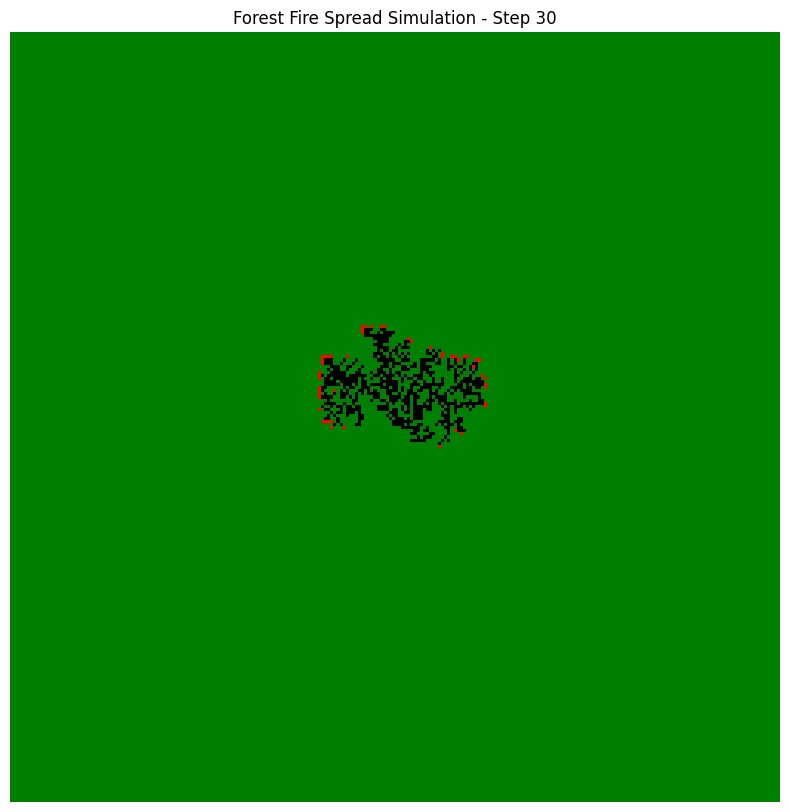

In [9]:
# Visualize the simulation
model.visualize_simulation(history)


Evaluating simulation against actual burn perimeter data:
Accuracy: 0.5310
Precision: 1.0000 (correctly predicted burned area / total predicted burned area)
Recall: 0.0209 (correctly predicted burned area / actual burned area)
F1 Score: 0.0410
Sørensen Index: 0.0410


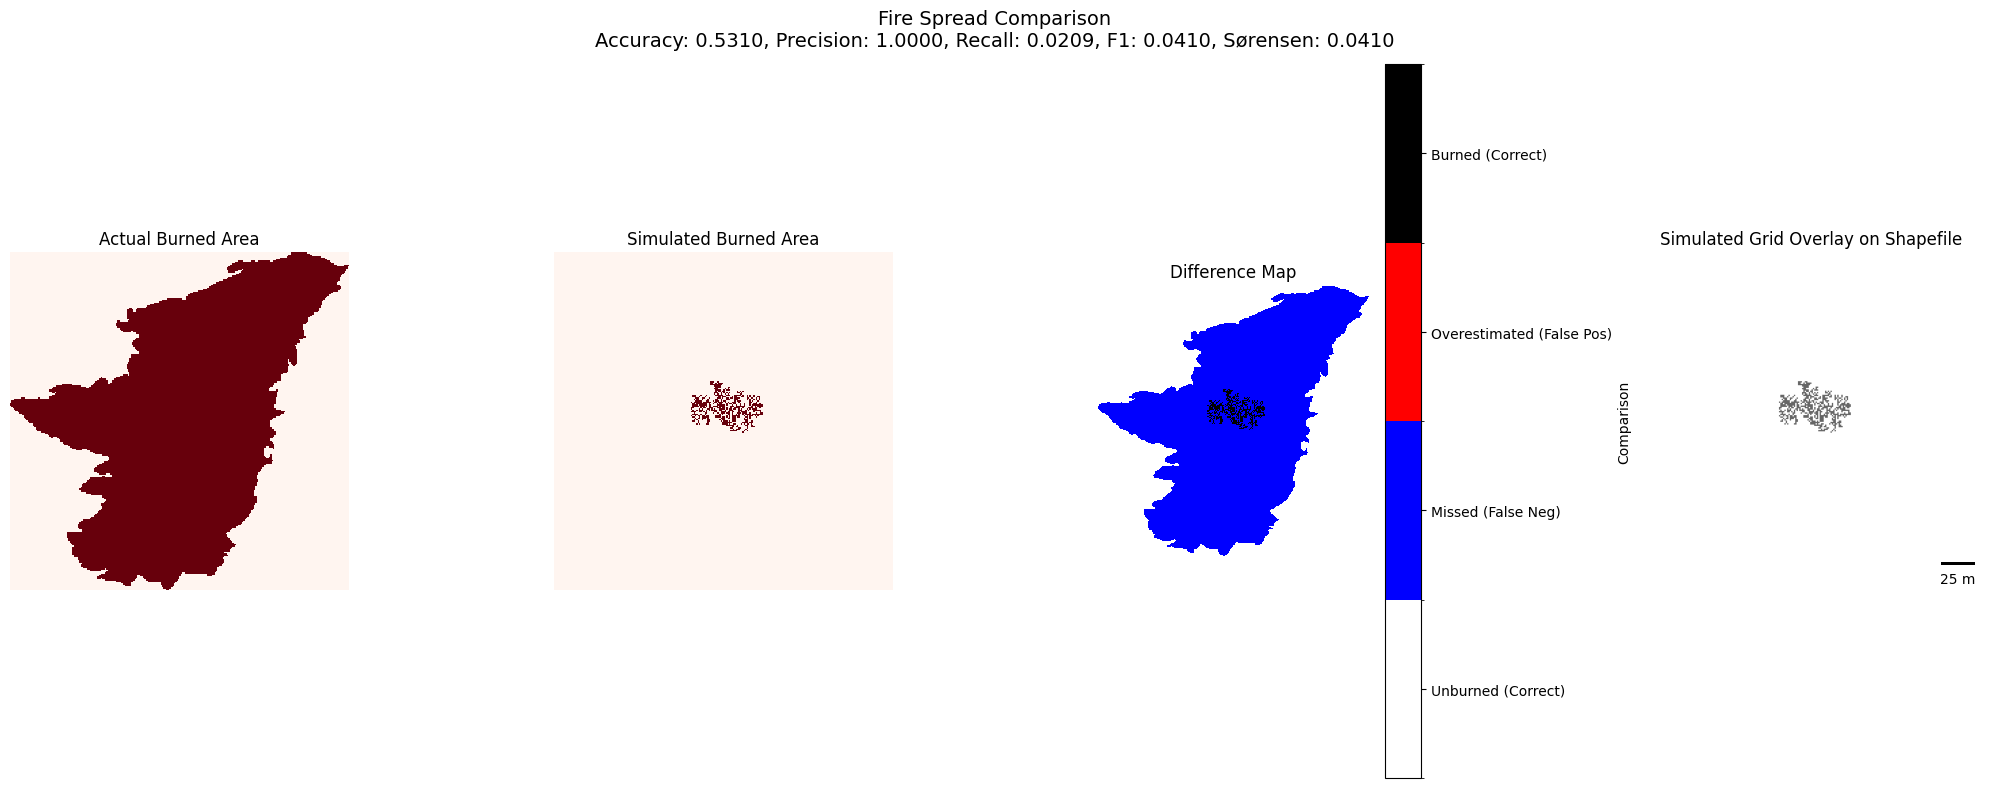

In [10]:
if model.actual_burned_area is not None:
    print("\nEvaluating simulation against actual burn perimeter data:")
    accuracy, precision, recall, sorensen = model.evaluate_simulation()
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f} (correctly predicted burned area / total predicted burned area)")
    print(f"Recall: {recall:.4f} (correctly predicted burned area / actual burned area)")
    print(f"F1 Score: {f1:.4f}")
    print(f"Sørensen Index: {sorensen:.4f}")

    # Create the comparison visualization
    fig = model.overlay_simulation_with_actual(fire)
    plt.show()

In [11]:
from src.interventions import apply_firebreak_strategy, apply_early_detection_strategy, apply_direct_attack_strategy, apply_point_protection_strategy


Evaluating strategy: No Intervention (Baseline)
Description: No firefighting intervention
Loaded burn perimeter shapefile: data/az3698311211020200729/az3698311211020200729_20200714_20210717_burn_bndy.shp
Loaded DNBR raster: data/az3698311211020200729/az3698311211020200729_20200714_20210717_dnbr.tif
Initializing from arizona fire
Loaded burn perimeter successfully
Resampling DNBR data from (565, 499) to (250, 250)
Estimated NDVI from DNBR data
 prob: 0.5, we: 0.10375017142416093, a_prob: 0.09394324500624622, tp: 0.475, p_density: 0.8018129615227354, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.5, we: 0.10375017142416093, a_prob: 20.60829813483217, tp: 0.375, p_density: 0.7952676482798644, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.5, we: 0.10375017142416093, a_prob: 0.0021983940958501436, tp: 0.475, p_density: 0.7892545123617511, humidity: 2.7676539171301524, temperature: 2.6379444593541526, p

/content/MX4553_Modelling_Theory_Project/src/model.py:151: RuntimeWarning: overflow encountered in exp
  slope_factor = np.exp((3.533 * (np.tan(slope))))


 prob: 0.5, we: 0.10375017142416093, a_prob: 0.005311182800199822, tp: 0.075, p_density: 0.8157440683533189, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.5, we: 0.10375017142416093, a_prob: 0.10651427332555465, tp: 0.075, p_density: 0.8043521405512455, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.5, we: 0.10375017142416093, a_prob: 0.009542854936818338, tp: 0.275, p_density: 0.7800593850354534, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.5, we: 0.10375017142416093, a_prob: 0.025113680457638635, tp: 0.1, p_density: 0.8004145093856876, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.5, we: 0.10375017142416093, a_prob: 1.8896339451970335e-40, tp: 0.075, p_density: 0.7897880899547916, humidity: 2.7676539171301524, temperature: 2.6379444593541526, precipitation: 1.0
 prob: 0.5, we: 0.10375017142416093, a_prob: 3

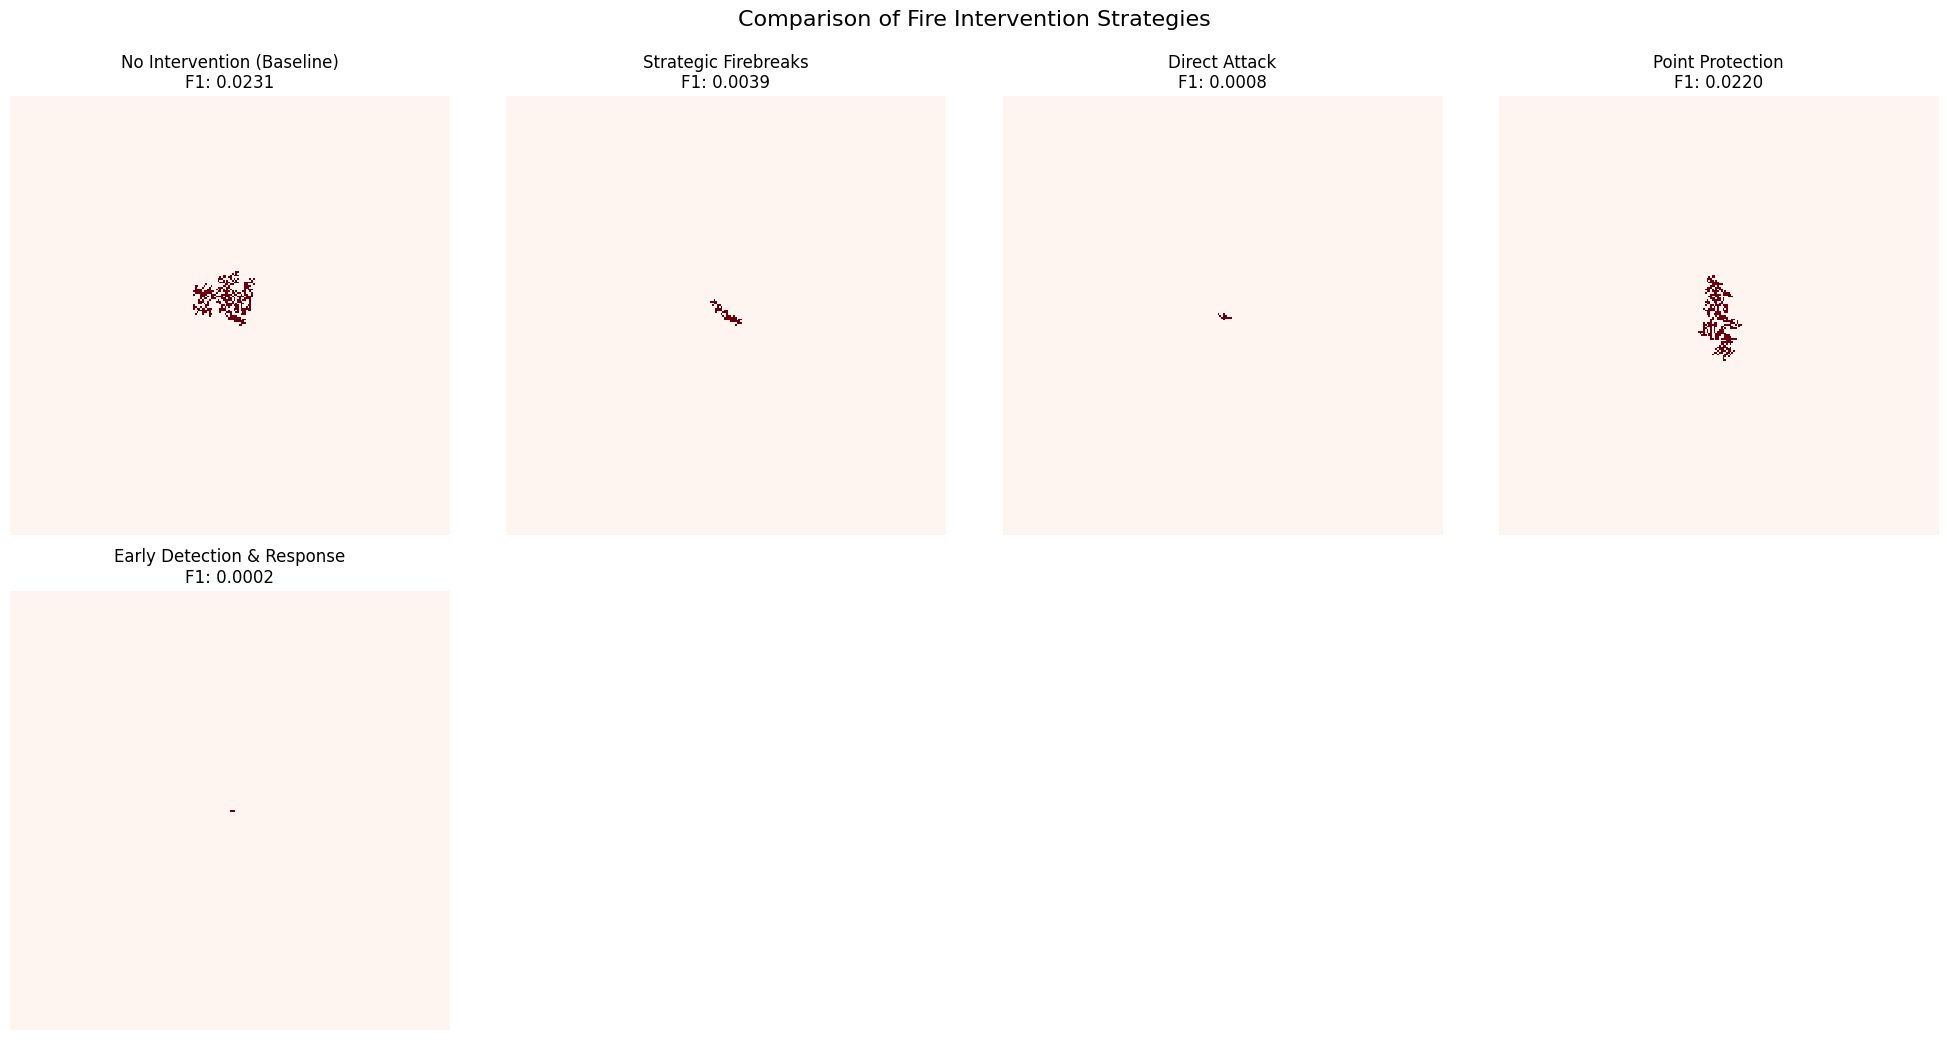

In [12]:
# Define intervention strategies
strategies = {
    'no_intervention': {
        'name': 'No Intervention (Baseline)',
        'description': 'No firefighting intervention',
        'function': lambda model, steps: model.run_simulation(steps)
    },
    'firebreaks': {
        'name': 'Strategic Firebreaks',
        'description': 'Create firebreaks to control fire spread',
        'function': apply_firebreak_strategy
    },
    'direct_attack': {
        'name': 'Direct Attack',
        'description': 'Directly attack the fire front with fire retardant',
        'function': apply_direct_attack_strategy
    },
    'point_protection': {
        'name': 'Point Protection',
        'description': 'Focus resources on protecting specific high-value points',
        'function': apply_point_protection_strategy
    },
    'early_detection': {
        'name': 'Early Detection & Response',
        'description': 'Early detection and rapid initial attack',
        'function': apply_early_detection_strategy
    }
}

# Store results for comparison
results = {}
baseline_result = None

# Create a figure for visualization of all strategies
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# Set the initial fire locations
initial_fire = [(50, 50)]

# Run simulation for each strategy
for i, (strategy_id, strategy) in enumerate(strategies.items()):
    print(f"\nEvaluating strategy: {strategy['name']}")
    print(f"Description: {strategy['description']}")

    # Clone the base model for this strategy
    model = CA(grid_size=grid_size, cell_size=1)
    model.load_mtbs_fire_data(fire)
    model.initialise_ndvi_from_data(fire)
    model.load_terrain_data(slope, aspect, elevation, humidity)
    model.set_environmental_data(wind_speed=5.0, wind_direction=225.0, temperature=50, humidity=5, fire_direction=20)
    # model.set_initial_fire(initial_fire)

    # Apply the strategy and run simulation
    history = strategy['function'](model, 30)

    # Evaluate results
    if model.actual_burned_area is not None:
        accuracy, precision, recall, sorensen = model.evaluate_simulation()
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Save metrics
        results[strategy_id] = {
            'name': strategy['name'],
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'sorensen': sorensen,
            'burned_area': np.sum(model.grid == 2),  # Count of burned cells
            'burnt_grid': (model.grid == 2).astype(int)  # Save the burnt grid for visualization
        }

        # Save baseline result for comparison
        if strategy_id == 'no_intervention':
            baseline_result = results[strategy_id]

        # Plot results
        ax = axes[i]
        ax.imshow(model.grid == 2, cmap='Reds', interpolation='none')
        ax.set_title(f"{strategy['name']}\nF1: {f1:.4f}")
        ax.axis('off')

        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  Burned Area: {results[strategy_id]['burned_area']} cells")

        # Calculate fire containment percentage if not baseline
        if baseline_result and strategy_id != 'no_intervention':
            containment = 1.0 - (results[strategy_id]['burned_area'] / baseline_result['burned_area'])
            containment_pct = max(0, containment * 100)
            results[strategy_id]['containment_pct'] = containment_pct
            print(f"  Fire Containment: {containment_pct:.1f}%")

# Fill any unused subplot spaces
for i in range(len(strategies), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle("Comparison of Fire Intervention Strategies", fontsize=16, y=1.02)
plt.show()

<ipython-input-13-718c734846f5>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(strategies, rotation=45, ha='right')
<ipython-input-13-718c734846f5>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(strategies, rotation=45, ha='right')


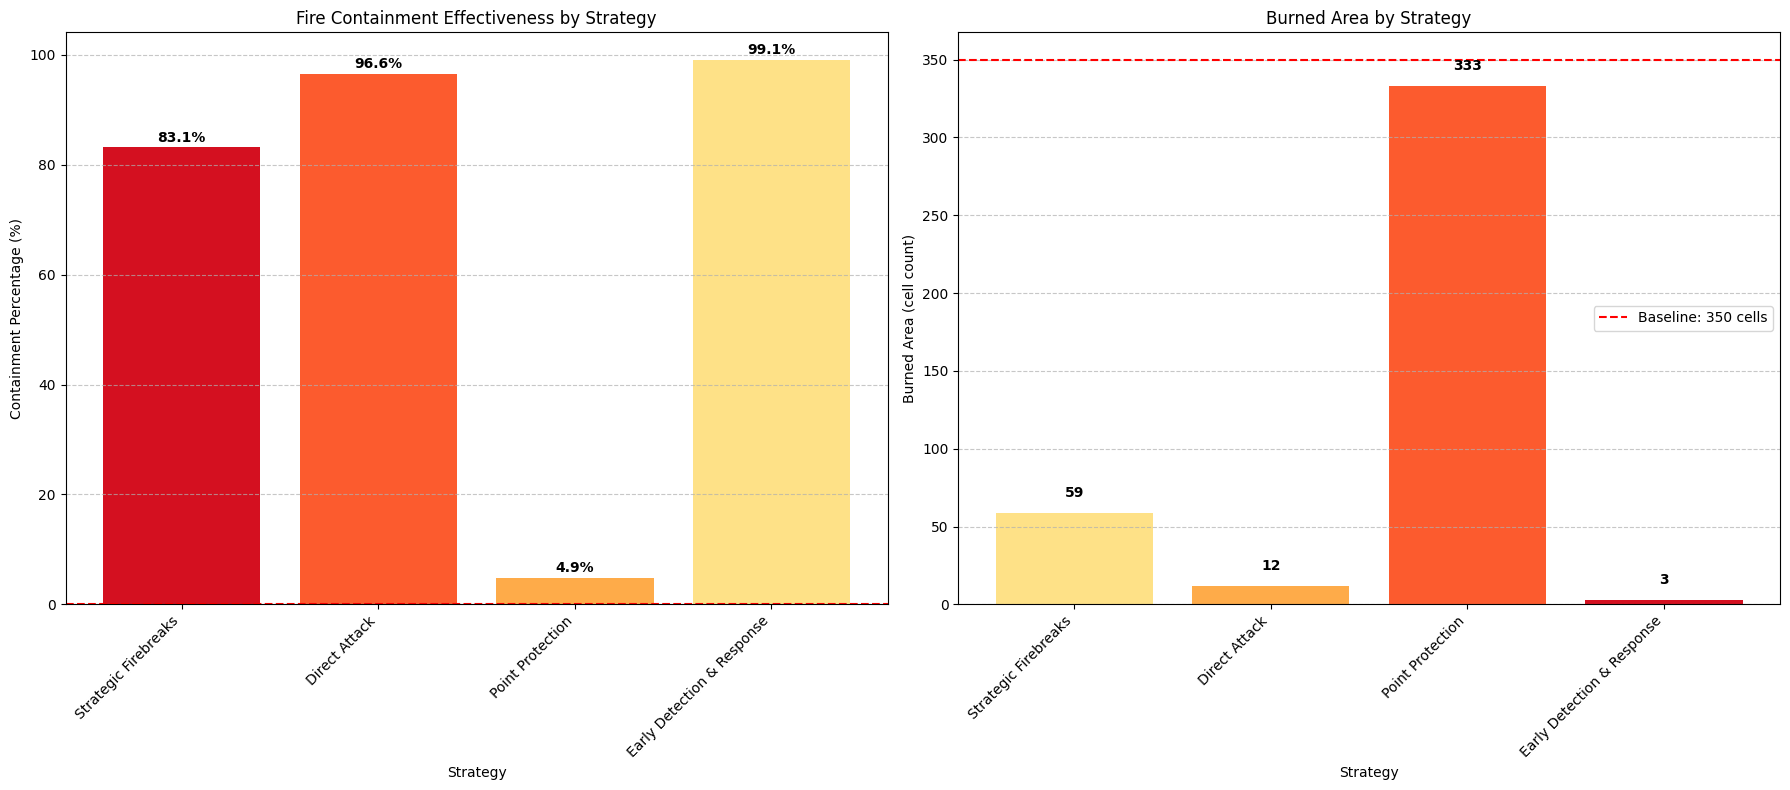

In [13]:
# Extract strategy names and containment percentages
strategies = []
containment_pcts = []
burned_areas = []

for strategy_id, metrics in results.items():
    if strategy_id != 'no_intervention':
        strategies.append(metrics['name'])
        containment_pcts.append(metrics.get('containment_pct', 0))
        burned_areas.append(metrics['burned_area'])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot containment percentages
containment_colors = plt.cm.YlOrRd(np.linspace(0.8, 0.2, len(strategies)))
ax1.bar(strategies, containment_pcts, color=containment_colors)
ax1.set_title('Fire Containment Effectiveness by Strategy')
ax1.set_ylabel('Containment Percentage (%)')
ax1.set_xlabel('Strategy')
ax1.set_xticklabels(strategies, rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add baseline reference line
ax1.axhline(y=0, color='r', linestyle='--', label='Baseline (No Intervention)')

# Add labels on bars
for i, v in enumerate(containment_pcts):
    ax1.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

# Plot burned areas
burned_colors = plt.cm.YlOrRd(np.linspace(0.2, 0.8, len(strategies)))
ax2.bar(strategies, burned_areas, color=burned_colors)
ax2.set_title('Burned Area by Strategy')
ax2.set_ylabel('Burned Area (cell count)')
ax2.set_xlabel('Strategy')
ax2.set_xticklabels(strategies, rotation=45, ha='right')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add baseline reference line
baseline_area = baseline_result['burned_area']
ax2.axhline(y=baseline_area, color='r', linestyle='--', label=f'Baseline: {baseline_area} cells')
ax2.legend()

# Add labels on bars
for i, v in enumerate(burned_areas):
    ax2.text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


